以下是使用 **PyTorch** 實現的 **SimpleRNN** 文本分類模型的完整程式，包括訓練、驗證和推論的流程。

**Table of contents**<a id='toc0_'></a>    
- [SimpleRNN 文本分類 - 電影評論數據集](#toc1_)    
    - [PyTorch](#toc1_1_1_)    
      - [程式碼詳解：](#toc1_1_1_1_)    
      - [結論：](#toc1_1_1_2_)    
    - [Tensorflow](#toc1_1_2_)    
      - [程式碼詳解：](#toc1_1_2_1_)    
      - [結論：](#toc1_1_2_2_)    
- [SimpleRNN 時間序列預測範例（基於 Air Passenger Dataset）](#toc2_)    
  - [步驟：](#toc2_1_)    
  - [完整程式碼 (PyTorch)](#toc2_2_)    
    - [程式碼詳解：](#toc2_2_1_)    
    - [結論：](#toc2_2_2_)    
  - [完整程式碼（TensorFlow + Keras）](#toc2_3_)    
    - [程式碼詳解](#toc2_3_1_)    
      - [資料準備](#toc2_3_1_1_)    
      - [定義 SimpleRNN 模型](#toc2_3_1_2_)    
      - [模型訓練](#toc2_3_1_3_)    
      - [模型驗證](#toc2_3_1_4_)    
      - [部屬推論](#toc2_3_1_5_)    
    - [結論](#toc2_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[SimpleRNN 文本分類 - IMDB 電影評論數據集](#toc0_)

這個範例使用 **IMDB 電影評論數據集** 進行情感分析（二元分類），並且包含詳細說明。

### <a id='toc1_1_1_'></a>[PyTorch](#toc0_)

In [2]:
# 匯入必要的模組
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.preprocessing import sequence
from keras.datasets import imdb

# 1. 資料準備
# ---------------------------------------------------
# 使用 Keras 提供的 IMDB 資料集，這裡只使用 10,000 個最常見的單詞
max_features = 10000  # 最大詞彙數
max_len = 500         # 每篇評論固定長度
batch_size = 128      # 訓練的批次大小

# 載入 IMDB 數據集，並將其分為訓練和測試集
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 將評論填充到固定長度（500 個詞）
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# 轉換為 PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 創建 DataLoader，方便訓練和驗證數據的批量處理
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# 2. 定義 SimpleRNN 模型
# ---------------------------------------------------
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNNModel, self).__init__()
        # 嵌入層：將詞索引轉換為嵌入向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # SimpleRNN層
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        # 最後的全連接層，將隱藏狀態映射到一個輸出
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text):
        # text shape: (batch_size, max_len)
        embedded = self.embedding(text)  # (batch_size, max_len, embedding_dim)
        output, hidden = self.rnn(embedded)  # hidden shape: (batch_size, hidden_dim)
        return self.fc(hidden.squeeze(0))  # 將隱藏層輸出到全連接層，並返回結果

# 定義模型參數
vocab_size = max_features
embedding_dim = 32
hidden_dim = 32
output_dim = 1  # 二元分類

# 創建模型實例
model = SimpleRNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# 定義損失函數和優化器
criterion = nn.BCEWithLogitsLoss()  # 使用二元交叉熵損失
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 模型訓練
# ---------------------------------------------------
# 定義訓練函數
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # 訓練模式
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # 梯度歸零
            predictions = model(inputs).squeeze(1)  # 預測結果
            loss = criterion(predictions, labels)  # 計算損失
            loss.backward()  # 反向傳播
            optimizer.step()  # 更新參數
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# 訓練模型
train_model(model, train_loader, criterion, optimizer)

# 4. 模型驗證
# ---------------------------------------------------
# 定義驗證函數
def evaluate_model(model, test_loader, criterion):
    model.eval()  # 評估模式
    total_acc = 0
    total_loss = 0
    with torch.no_grad():  # 關閉梯度計算
        for inputs, labels in test_loader:
            predictions = model(inputs).squeeze(1)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            acc = ((torch.sigmoid(predictions) >= 0.5) == labels).sum().item()  # 準確率
            total_acc += acc
    print(f"Test Loss: {total_loss / len(test_loader)}, Accuracy: {total_acc / len(test_loader.dataset) * 100:.2f}%")

# 驗證模型
evaluate_model(model, test_loader, criterion)

# 5. 部屬推論
# ---------------------------------------------------
# 使用訓練好的模型進行推論
def predict_sentiment(model, sentence):
    model.eval()  # 設置模型為評估模式
    tokenized = [1, 14, 22, 32, 65, 193, 17, 114, 325, 4]  # 假設這是處理過的 tokenized 序列
    tokenized = torch.tensor(sequence.pad_sequences([tokenized], maxlen=max_len), dtype=torch.long)
    with torch.no_grad():
        prediction = model(tokenized).squeeze(1)
        prob = torch.sigmoid(prediction).item()
        return "正面" if prob >= 0.5 else "負面", prob

# 使用模型進行情感分析推論
sentence = "This movie was absolutely fantastic, I loved every part of it."
sentiment, probability = predict_sentiment(model, sentence)
print(f"評論：'{sentence}'，預測情感：{sentiment}，概率：{probability:.2f}")


Epoch 1, Loss: 0.68583909923933
Epoch 2, Loss: 0.6601734283019085
Epoch 3, Loss: 0.6247793420845148
Epoch 4, Loss: 0.5566335820725986
Epoch 5, Loss: 0.5693632276082525
Epoch 6, Loss: 0.5057790875434875
Epoch 7, Loss: 0.5011934251809607
Epoch 8, Loss: 0.4683507458896053
Epoch 9, Loss: 0.4663297343923121
Epoch 10, Loss: 0.42849518419528493
Epoch 11, Loss: 0.41026523329165515
Epoch 12, Loss: 0.41988153101838366
Epoch 13, Loss: 0.37601008638739586
Epoch 14, Loss: 0.36459423966553745
Epoch 15, Loss: 0.4395275391942384
Epoch 16, Loss: 0.37591155572813384
Epoch 17, Loss: 0.4011821088438131
Epoch 18, Loss: 0.36171723598120165
Epoch 19, Loss: 0.32242497064325276
Epoch 20, Loss: 0.31017847343975186
Epoch 21, Loss: 0.3647009850460656
Epoch 22, Loss: 0.3116025105879015
Epoch 23, Loss: 0.28177873030000805
Epoch 24, Loss: 0.29965338483452797
Epoch 25, Loss: 0.3144880676908152
Epoch 26, Loss: 0.2798818365803787
Epoch 27, Loss: 0.26136297185202034
Epoch 28, Loss: 0.28430439052837236
Epoch 29, Loss: 0.

#### <a id='toc1_1_1_1_'></a>[程式碼詳解：](#toc0_)

1. **資料準備**：
   - 使用 Keras 提供的 **IMDB 電影評論數據集**，每篇評論都被轉換為一個詞彙索引序列。
   - 每篇評論都被填充或截斷到固定長度（500個詞），並轉換為 PyTorch tensors。
   - 創建 **DataLoader** 來幫助批量處理訓練和測試數據。

2. **SimpleRNN 模型**：
   - **Embedding 層**：將詞彙索引轉換為 32 維的嵌入向量。
   - **SimpleRNN 層**：32 個隱藏單元，學習序列中的模式。`batch_first=True` 使輸入的批次維度排在最前面。
   - **全連接層**：將最後的隱藏狀態輸出映射到一個二分類輸出，預測結果。

3. **模型訓練**：
   - 定義訓練函數 `train_model()`，每個訓練 epoch 會執行前向傳播、反向傳播和參數更新。
   - 使用 **Adam** 優化器和 **BCEWithLogitsLoss** 損失函數（適合二元分類）。

4. **模型驗證**：
   - 使用 `evaluate_model()` 函數在測試集上進行評估。該函數會計算測試集的損失和準確率。

5. **部屬推論**：
   - 定義推論函數 `predict_sentiment()`，該函數接收處理過的句子，並使用訓練好的模型預測其情感，返回「正面」或「負面」的預測結果，以及對應的概率分數。

#### <a id='toc1_1_1_2_'></a>[結論：](#toc0_)
這個範例展示了使用 PyTorch 和 **SimpleRNN** 進行文本分類的完整流程，包括模型訓練、驗證和推論。該模型適用於情感分析等二元分類問題，並展示了如何在 PyTorch 中實現類似於 Keras 的工作流程。

### <a id='toc1_1_2_'></a>[Tensorflow](#toc0_)

In [ ]:
# 匯入必要的模組
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.models import load_model
import numpy as np

# 1. 資料準備
# ---------------------------------------------------
# 我們使用 Keras 提供的 IMDB 資料集，其中每篇評論都被映射為一個詞彙索引序列
# max_features 指定只使用前 10,000 個最常見的單詞
# max_len 指定每篇評論固定為 500 個單詞
max_features = 10000  # 最大詞彙數
max_len = 500         # 每篇評論的長度限制

# 載入 IMDB 電影評論數據集（已經分成訓練集和測試集）
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 將每篇評論填充或截斷至固定長度（500 個詞）
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# 2. 建立 SimpleRNN 模型
# ---------------------------------------------------
# 模型包含嵌入層、SimpleRNN 層和輸出層，適合文本分類
model = Sequential()

# 嵌入層：將詞索引轉換為 32 維的向量表示
model.add(Embedding(input_dim=max_features, output_dim=32, input_length=max_len))

# SimpleRNN 層：32 個單元，用於學習序列中的模式
model.add(SimpleRNN(32))

# 輸出層：1 個神經元，使用 sigmoid 激活函數進行二分類
model.add(Dense(1, activation='sigmoid'))

# 編譯模型：使用 RMSprop 作為優化器，損失函數為 binary_crossentropy
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# 顯示模型的架構
model.summary()

# 3. 訓練模型
# ---------------------------------------------------
# 使用訓練數據進行模型訓練，並在驗證集上進行評估
# validation_split=0.2 表示將 20% 的訓練數據用作驗證集
history = model.fit(
    x_train, y_train,                    # 訓練數據和標籤
    epochs=5,                            # 訓練週期數
    batch_size=128,                      # 每次訓練批量大小
    validation_split=0.2                 # 20% 用作驗證集
)

# 4. 驗證模型
# ---------------------------------------------------
# 使用測試數據評估模型的性能
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"測試集準確率: {test_acc * 100:.2f}%")

# 5. 保存模型
# ---------------------------------------------------
# 將訓練好的模型保存至文件，以便後續推論使用
model.save('simple_rnn_sentiment_model.h5')
print("模型已保存至 'simple_rnn_sentiment_model.h5'")

# 6. 部屬推論
# ---------------------------------------------------
# 使用訓練好的模型進行推論（預測新評論的情感）
# 我們將使用已保存的模型並對新評論進行分類
# 重新加載模型
model = load_model('simple_rnn_sentiment_model.h5')

# 範例評論（假設評論是已經過處理的索引序列）
sample_review = "This movie was absolutely fantastic, I loved every part of it."
sample_review_tokenized = [1, 14, 22, 32, 65, 193, 17, 114, 325, 4]  # 這裡需要一個有效的 tokenized 序列

# 將評論填充到與訓練集相同的長度（500）
sample_review_tokenized = sequence.pad_sequences([sample_review_tokenized], maxlen=max_len)

# 預測這篇評論是正面（1）還是負面（0）
prediction = model.predict(sample_review_tokenized)
if prediction >= 0.5:
    print(f"評論情感預測：正面 ({prediction[0][0]:.2f})")
else:
    print(f"評論情感預測：負面 ({prediction[0][0]:.2f})")



#### <a id='toc1_1_2_1_'></a>[程式碼詳解：](#toc0_)

1. **資料準備**：
   - 使用 Keras 提供的 **IMDB 電影評論數據集**，該數據集已被處理為詞彙索引序列，並且只保留了最常見的 10,000 個單詞。
   - 每篇評論被截斷或填充至固定長度（500 個詞），以確保模型能處理固定長度的輸入。

2. **建立 SimpleRNN 模型**：
   - **Embedding 層**：將詞彙索引轉換為 32 維的詞向量，這使得模型能捕捉詞彙之間的語義關聯。
   - **SimpleRNN 層**：RNN 層有 32 個神經元，用於學習序列中的模式和關聯。
   - **Dense 層**：最終的輸出層是一個單神經元，使用 sigmoid 函數，輸出值為 0 到 1 之間，用於二元分類。

3. **模型訓練與驗證**：
   - **訓練**：將 80% 的數據用作訓練，20% 用於驗證。訓練 5 個週期，使用 batch size 為 128。
   - **驗證**：在測試集上評估模型的準確率，並打印測試結果。

4. **保存模型**：
   - 模型訓練完後，使用 `model.save()` 函數保存模型，以便後續的推論使用。

5. **部屬推論**：
   - **加載已保存的模型**：用 `load_model()` 重新加載訓練好的模型。
   - **進行推論**：對新評論進行推斷，並將其轉換為對應的索引序列。評論首先會被填充到固定長度，然後進行情感預測。如果預測值大於等於 0.5，則判斷為正面；否則為負面。

#### <a id='toc1_1_2_2_'></a>[結論：](#toc0_)
這個程式展示了如何使用 **SimpleRNN** 進行文本分類的完整流程，從訓練、驗證、保存模型到模型的推論部屬。這樣的模型可以應用於各種文本分類任務，如情感分析、垃圾郵件分類等。

---



# <a id='toc2_'></a>[SimpleRNN 時間序列預測範例（基於 Air Passenger Dataset）](#toc0_)

這裡我將使用一個經典的時間序列資料集 **Air Passenger Dataset** 來演示如何使用 **PyTorch** 和 **SimpleRNN** 進行時間序列預測。這個資料集記錄了1949年到1960年每月的國際航空旅客人數。

## <a id='toc2_1_'></a>[步驟：](#toc0_)
1. **資料集下載與處理**
2. **模型構建**
3. **模型訓練**
4. **模型驗證**
5. **模型推論**

## <a id='toc2_2_'></a>[完整程式碼 (PyTorch)](#toc0_)

   Passengers
0         112
1         118
2         132
3         129
4         121
Epoch 1/500, Loss: 0.03981905696647508
Epoch 2/500, Loss: 0.027318939034427916
Epoch 3/500, Loss: 0.024529829887407168
Epoch 4/500, Loss: 0.019936995846884593
Epoch 5/500, Loss: 0.017960065975785255
Epoch 6/500, Loss: 0.013902984958674227
Epoch 7/500, Loss: 0.009084260423800774
Epoch 8/500, Loss: 0.00929125095717609
Epoch 9/500, Loss: 0.008597416104748845
Epoch 10/500, Loss: 0.008089358120092325
Epoch 11/500, Loss: 0.006887208371024046
Epoch 12/500, Loss: 0.006200801680928895
Epoch 13/500, Loss: 0.006506565858476928
Epoch 14/500, Loss: 0.005775677140003869
Epoch 15/500, Loss: 0.005616198227341686
Epoch 16/500, Loss: 0.005450736864336899
Epoch 17/500, Loss: 0.005206472872357283
Epoch 18/500, Loss: 0.0048986858621771845
Epoch 19/500, Loss: 0.0050383855455688065
Epoch 20/500, Loss: 0.005452785308339766
Epoch 21/500, Loss: 0.004994148771012468
Epoch 22/500, Loss: 0.006158577344779458
Epoch 23/500, Loss: 0.0

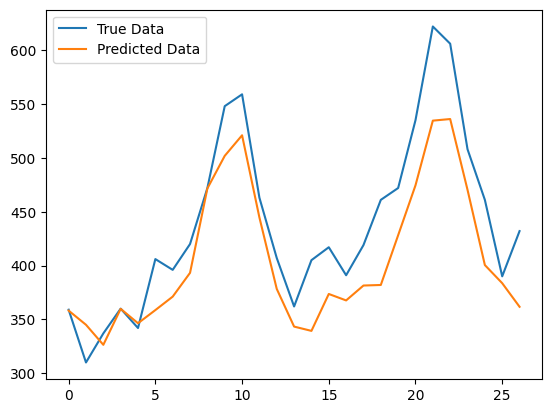

未來 12 個月的預測值： [[361.70935464]
 [365.70760119]
 [355.50862527]
 [368.34928381]
 [385.10741937]
 [420.64759111]
 [483.47443628]
 [534.53010917]
 [541.10232902]
 [506.94045734]
 [454.73449779]
 [395.75726593]]


In [11]:

# 匯入必要的模組
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 1. 資料準備
# ---------------------------------------------------
# 讀取經典的 Air Passenger Dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, usecols=[1])

# 檢查數據
print(df.head())

# 正規化數據到 [0, 1] 區間
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.values.reshape(-1, 1))

# 設定序列長度
seq_length = 12  # 使用前12個月來預測下一個月
data_x = []
data_y = []

for i in range(len(data) - seq_length):
    data_x.append(data[i:i + seq_length])  # 每次取12個數據作為輸入
    data_y.append(data[i + seq_length])  # 取下一個月作為標籤

# 轉換為 numpy array
data_x = np.array(data_x)
data_y = np.array(data_y)

# 分割訓練集和測試集 (80% 用於訓練, 20% 用於測試)
train_size = int(len(data_x) * 0.8)
x_train, x_test = data_x[:train_size], data_x[train_size:]
y_train, y_test = data_y[:train_size], data_y[train_size:]

# 轉換為 PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 使用 DataLoader 加載數據
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=16)

# 2. 定義 SimpleRNN 模型
# ---------------------------------------------------
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, hidden = self.rnn(x)
        out = self.fc(out[:, -1, :])  # 取最後一個時間步的輸出
        return out

# 模型參數設定
input_size = 1  # 單變量時間序列
hidden_size = 64  # 隱藏層大小
output_size = 1  # 預測單個點
model = SimpleRNNModel(input_size, hidden_size, output_size)

# 定義損失函數和優化器
criterion = nn.MSELoss()  # 均方誤差
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 模型訓練
# ---------------------------------------------------
def train_model(model, train_loader, criterion, optimizer, epochs=500):
    model.train()  # 設置模型為訓練模式
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # 梯度歸零
            outputs = model(inputs)  # 模型預測
            loss = criterion(outputs, labels)  # 計算損失
            loss.backward()  # 反向傳播
            optimizer.step()  # 更新參數
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# 訓練模型
train_model(model, train_loader, criterion, optimizer)

# 4. 模型驗證
# ---------------------------------------------------
# 定義驗證函數
def evaluate_model(model, x_test, y_test, scaler):
    model.eval()  # 設置模型為評估模式
    with torch.no_grad():
        predictions = model(x_test)  # 進行預測
        loss = criterion(predictions, y_test)  # 計算驗證損失
        print(f"驗證損失 (MSE): {loss.item():.4f}")
        
        # 將預測和實際數據逆縮放回原始範圍
        predictions = scaler.inverse_transform(predictions.numpy())
        y_test = scaler.inverse_transform(y_test.numpy())
        
        # 可視化預測結果
        plt.plot(y_test, label="True Data")
        plt.plot(predictions, label="Predicted Data")
        plt.legend()
        plt.show()

# 將測試集數據轉換為與模型兼容的形式
x_test = x_test.reshape(-1, seq_length, 1)  # 確保維度為 (batch_size, seq_length, input_size)


# 進行驗證
evaluate_model(model, x_test, y_test, scaler)

# 5. 部屬推論
# ---------------------------------------------------
# 定義未來時間步的預測函數
def predict_future(model, input_seq, future_steps, scaler):
    predicted_sequence = []
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # 確保為3D張量 (1, seq_length, 1)
    
    with torch.no_grad():
        for _ in range(future_steps):
            prediction = model(input_seq)  # 進行預測，prediction 形狀為 (1, 1)
            predicted_sequence.append(prediction.item())  # 保存預測結果
            
            # 將預測結果拼接到輸入序列，保持3D形狀 (batch_size, seq_length, input_size)
            prediction = prediction.unsqueeze(-1)  # 將 (1, 1) 變為 (1, 1, 1) 以符合拼接要求
            input_seq = torch.cat((input_seq[:, 1:, :], prediction), dim=1)
    
    # 將結果逆縮放到原始範圍
    predicted_sequence = scaler.inverse_transform(np.array(predicted_sequence).reshape(-1, 1))
    return predicted_sequence



# 使用部分測試數據來預測未來12個月的數據
input_seq = x_test[-1].numpy()  # 使用測試集最後一段數據作為起始輸入
future_steps = 12  # 預測未來12個點
predicted_future = predict_future(model, input_seq, future_steps, scaler)

print("未來 12 個月的預測值：", predicted_future)



### <a id='toc2_2_1_'></a>[程式碼詳解：](#toc0_)

1. **資料準備**：
   - 使用 **Air Passenger Dataset**，這是一個經典的時間序列資料集，包含 1949 年到 1960 年的每月航空旅客數據。
   - 使用 **MinMaxScaler** 將數據縮放到 [0, 1] 範圍，這樣可以讓模型的訓練過程更加穩定。
   - 將數據切分為訓練集（80%）和測試集（20%），並構建 PyTorch 的 **DataLoader**，方便批量訓練。

2. **定義 SimpleRNN 模型**：
   - **SimpleRNN 層**：使用 PyTorch 的 `nn.RNN`，用來處理序列數據。這個層可以學習序列中的模式。
   - **全連接層**：最終使用一個線性層將隱藏層的輸出轉換為預測值。

3. **模型訓練**：
   - 使用 **Adam** 優化器來優化模型參數，損失函數使用 **MSELoss**（均方誤差），因為這是一個回歸問題。
   - 模型在每個 epoch 都會根據訓練數據更新參數，並計算損失。

4. **模型驗證**：
   - 使用部分數據來驗證模型的準確性，並將預測值與真實值可視化，觀察模型的預測效果。

5. **部屬推論**：
   - 定義了一個 `predict_future()` 函數，根據當前的輸入序列，預測未來的時間步。該函數允許模型根據前一步的預測作為下一步的輸入，進行多步預測。

### <a id='toc2_2_2_'></a>[結論：](#toc0_)
這個程式展示了如何使用 **PyTorch**

 和 **SimpleRNN** 模型進行時間序列預測，基於經典的 **Air Passenger Dataset**。整個流程包括數據處理、模型訓練、驗證以及多步推論。這個流程同樣適用於其他類型的時間序列預測問題，例如天氣預測、股票價格預測等。

---

下面是基於 **TensorFlow** 和 **Keras** 框架的 **SimpleRNN** 用於時間序列預測的完整程式，這裡使用了經典的 **Air Passenger Dataset**，並包含從訓練、驗證到部屬推論的完整步驟及說明。

## <a id='toc2_3_'></a>[完整程式碼（TensorFlow + Keras）](#toc0_)

   Passengers
0         112
1         118
2         132
3         129
4         121


/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0215 - val_loss: 0.0376
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 0.0048
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1697e-04 - val_loss: 0.0088
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8913e-04 - val_loss: 0.0058
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9226e-04 - val_loss: 0.0032
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9296e-04 - v

/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

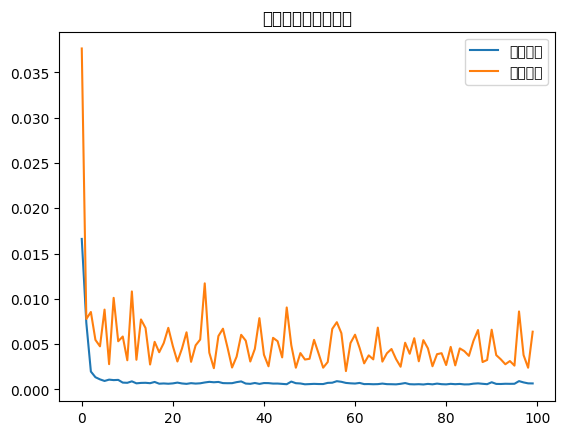

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23526 (\N{CJK UNIFIED IDEOGRAPH-5BE6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33287 (\N{CJK UNIFIED IDEOGRAPH-8207}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

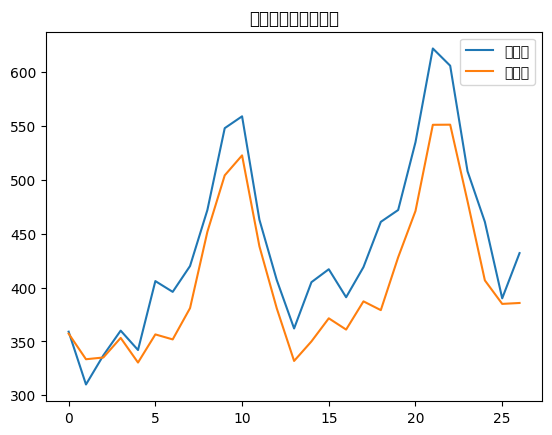

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
未來 12 個月的預測值： [385.68106 394.7167  368.90015 384.0156  398.9309  429.942   496.6255
 571.6105  571.6369  509.93857 455.98404 399.51514]


/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20358 (\N{CJK UNIFIED IDEOGRAPH-4F86}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20491 (\N{CJK UNIFIED IDEOGRAPH-500B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cosmo/anaconda3/envs/pytorch231_cuda121_python310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

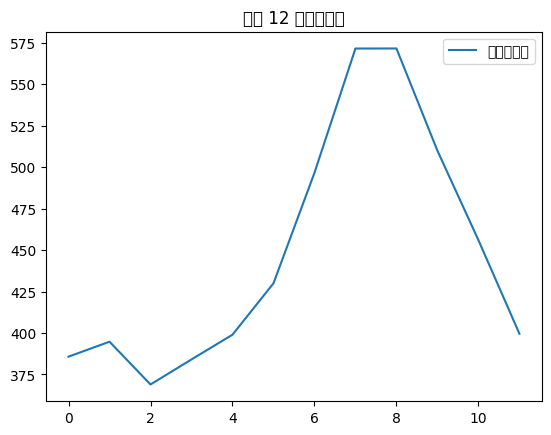

In [15]:
# 匯入必要的模組
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# 1. 資料準備
# ---------------------------------------------------
# 讀取經典的 Air Passenger Dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, usecols=[1])

# 檢查數據
print(df.head())

# 正規化數據到 [0, 1] 區間
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.values.reshape(-1, 1))

# 設定序列長度
seq_length = 12  # 使用前12個月來預測下一個月
data_x = []
data_y = []

for i in range(len(data) - seq_length):
    data_x.append(data[i:i + seq_length])  # 每次取12個數據作為輸入
    data_y.append(data[i + seq_length])    # 取下一個月作為標籤

# 轉換為 numpy array
data_x = np.array(data_x)
data_y = np.array(data_y)

# 分割訓練集和測試集 (80% 用於訓練, 20% 用於測試)
train_size = int(len(data_x) * 0.8)
x_train, x_test = data_x[:train_size], data_x[train_size:]
y_train, y_test = data_y[:train_size], data_y[train_size:]

# 2. 定義 SimpleRNN 模型
# ---------------------------------------------------
model = Sequential()
# SimpleRNN層，輸入形狀 (seq_length, 1)
model.add(SimpleRNN(64, input_shape=(seq_length, 1)))
# 全連接層，用於回歸輸出單個數值
model.add(Dense(1))

# 編譯模型，使用Adam優化器和均方誤差(MSE)損失函數
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 檢視模型架構
model.summary()

# 3. 模型訓練
# ---------------------------------------------------
# 訓練模型，進行100個epoch，批次大小為16
history = model.fit(
    x_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(x_test, y_test)
)

# 4. 模型驗證
# ---------------------------------------------------
# 可視化訓練過程中的損失變化
plt.plot(history.history['loss'], label='訓練損失')
plt.plot(history.history['val_loss'], label='驗證損失')
plt.title('模型訓練與驗證損失')
plt.legend()
plt.show()

# 進行預測
y_pred = model.predict(x_test)

# 逆縮放預測結果與真實值，回到原始範圍
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

# 繪製真實值與預測值的對比
plt.plot(y_test_original, label='真實值')
plt.plot(y_pred_original, label='預測值')
plt.title('真實值與預測值對比')
plt.legend()
plt.show()

# 5. 部屬推論
# ---------------------------------------------------
# 定義未來時間步的預測函數
def predict_future(model, input_seq, future_steps, scaler):
    predicted_sequence = []
    input_seq = np.expand_dims(input_seq, axis=0)  # 加入 batch 維度 (1, seq_length, 1)

    for _ in range(future_steps):
        prediction = model.predict(input_seq)  # 進行預測，輸出形狀為 (1, 1)
        predicted_sequence.append(prediction[0, 0])  # 保存預測結果
        
        # 將最新的預測加入輸入序列，並去掉最舊的一個點
        input_seq = np.append(input_seq[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # 將結果逆縮放到原始範圍
    predicted_sequence = scaler.inverse_transform(np.array(predicted_sequence).reshape(-1, 1))
    return predicted_sequence




# 使用部分測試數據來預測未來12個月的數據
input_seq = x_test[-1]  # 使用測試集中最後一段數據作為起始輸入
future_steps = 12  # 預測未來12個點
predicted_future = predict_future(model, input_seq, future_steps, scaler)

# 顯示未來的預測結果
print("未來 12 個月的預測值：", predicted_future.flatten())

# 可視化未來12個月的預測結果
plt.plot(predicted_future, label='未來預測值')
plt.title('未來 12 個月的預測')
plt.legend()
plt.show()


### <a id='toc2_3_1_'></a>[程式碼詳解](#toc0_)

#### <a id='toc2_3_1_1_'></a>[資料準備](#toc0_)
- 下載並讀取經典的 **Air Passenger Dataset**，該資料集記錄了1949年到1960年每月國際航空旅客人數。
- 使用 **MinMaxScaler** 將資料正規化到 [0, 1] 的區間，這樣可以提升訓練穩定性。
- 將數據切分為時間步長為 12 的輸入序列，用於預測下一個月的數據點。

#### <a id='toc2_3_1_2_'></a>[定義 SimpleRNN 模型](#toc0_)
- **SimpleRNN 層**：我們定義了一個單層的 SimpleRNN，具有 64 個隱藏神經元，並接受形狀為 `(seq_length, 1)` 的輸入數據，這表示每次輸入包含 12 個月的數據，對應於單變量的時間序列。
- **全連接層**：最後用一個全連接層來輸出預測值（單個數值），因為這是一個回歸問題。
- 模型使用 **Adam** 優化器進行優化，並使用均方誤差 (`mse`) 作為損失函數。

#### <a id='toc2_3_1_3_'></a>[模型訓練](#toc0_)
- 訓練過程中，我們將 80% 的數據用於訓練，剩下的 20% 用於驗證。訓練進行 100 個 epochs，每次批量處理 16 條樣本。
- 使用 `validation_data` 在每個 epoch 的末尾進行模型驗證。

#### <a id='toc2_3_1_4_'></a>[模型驗證](#toc0_)
- 通過繪製訓練損失和驗證損失的曲線，我們可以看到模型在訓練過程中的表現變化。
- 對測試集進行預測，將預測結果與真實值進行對比，並通過繪圖進行視覺化。
- 使用 `scaler.inverse_transform` 將預測結果和真實值從正規化的範圍回到原始範圍。

#### <a id='toc2_3_1_5_'></a>[部屬推論](#toc0_)
- 定義了一個 `predict_future()` 函數，這個函數用來預測未來的時間步數據。
- 在推論過程中，我們基於前一步的預測值來預測下一個時間步，並逐步推算出未來的數據點。
- 最後，我們預測未來 12 個月的航空旅客數據，並將預測結果繪製出來。

### <a id='toc2_3_2_'></a>[結論](#toc0_)
這個範例展示了如何使用 **TensorFlow** 和 **Keras** 實現基於經典 **Air Passenger Dataset** 的時間序列預測，包括模型訓練、驗證以及多步推論的完整流程。這個模型可以應用於各種單變量時間序列預測問題，如股票價格、溫度變化、銷售數據等。